In [1]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# mount google drive to access data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# define paths
# dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection
path = "/content/drive/My Drive/01 - Courses/04 - Machine Learning Engineer Nanodegree/brain_tumor_detection/data/dataset"

In [4]:
# define parameters
img_height = 128
img_width = 128
img_size = (img_height, img_width)

In [5]:
def preprocess_data(path, img_size):
  '''
  Reads in images classified into folders, resizes and scales them. Returns 
  those processed images as features and their associated labels as well.
  Arguments:
    path (str) - path to classified image folders
    img_size (tuple) - tuple containing resized image height and width
  Returns:
    X (array) - features (brain scan images)
    y (array) - feature labels (0 - no tumor, 1 - tumor)
  '''

  unsuccessful_files = {}

  X = []
  y = []

  for folder_name in os.listdir(path):
    if folder_name == 'no':
      label = 0
    else:
      label = 1
    folder_path = os.path.join(path, folder_name)
  
    for fname in os.listdir(folder_path):
      fpath = os.path.join(folder_path, fname)
      try:
        img = cv2.imread(fpath)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        X.append(img)
        y.append(label)

      except Exception as e:
        unsuccessful_files[fname] = e

  if unsuccessful_files:
    print(f'Error processing the following files:\n')
    for index, key in enumerate(unsuccessful_files, 1):
      print(f'{index}. {key} - {unsuccessful_files[key]}')
  else:
    print('Successfully processed all images.')

  X = np.array(X)
  y = np.array(y)

  return X, y

In [6]:
# obtain features and labels
X, y = preprocess_data(path, img_size)

Successfully processed all images.


In [18]:
print(f'Our dataset has {len(X)} samples.')

Our dataset has 253 samples.


In [8]:
# split data into train, validation and test sets
from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

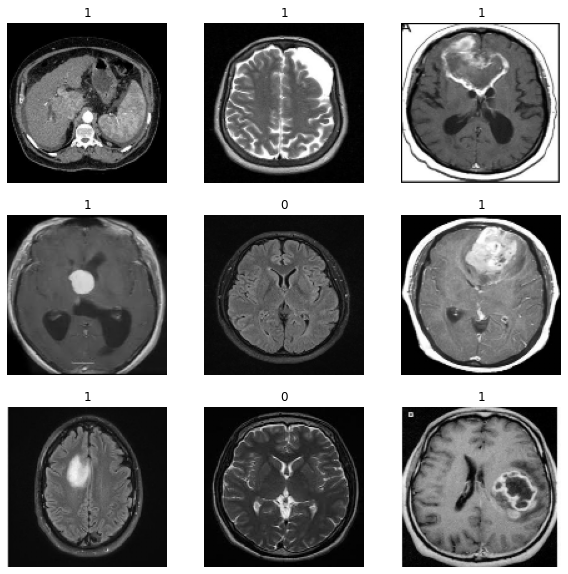

In [9]:
# visualize first 9 images in the training dataset
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.axis("off")

In [10]:
# create the model
model = Sequential([
  layers.Input((img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [11]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [12]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0

In [13]:
# train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
history = model.fit(
  X_train,
  y_train,
  batch_size=32,
  validation_data=(X_val, y_val),
  epochs=20,
  callbacks=[early_stop]
)

Epoch 1/20
6/6 [==============================] - 4s 600ms/step - loss: 0.6463 - accuracy: 0.5953 - val_loss: 0.5850 - val_accuracy: 0.7500
Epoch 2/20
6/6 [==============================] - 3s 506ms/step - loss: 0.4646 - accuracy: 0.7921 - val_loss: 0.6669 - val_accuracy: 0.7500
Epoch 3/20
6/6 [==============================] - 3s 515ms/step - loss: 0.4541 - accuracy: 0.8147 - val_loss: 0.5814 - val_accuracy: 0.7188
Epoch 4/20
6/6 [==============================] - 3s 511ms/step - loss: 0.3953 - accuracy: 0.8223 - val_loss: 0.6297 - val_accuracy: 0.7500
Epoch 5/20
6/6 [==============================] - 3s 502ms/step - loss: 0.3603 - accuracy: 0.8494 - val_loss: 0.5429 - val_accuracy: 0.7500
Epoch 6/20
6/6 [==============================] - 3s 502ms/step - loss: 0.2887 - accuracy: 0.8878 - val_loss: 0.6491 - val_accuracy: 0.7500
Epoch 7/20
6/6 [==============================] - 3s 506ms/step - loss: 0.2646 - accuracy: 0.8917 - val_loss: 0.6573 - val_accuracy: 0.7500
Epoch 8/20
6/6 [====

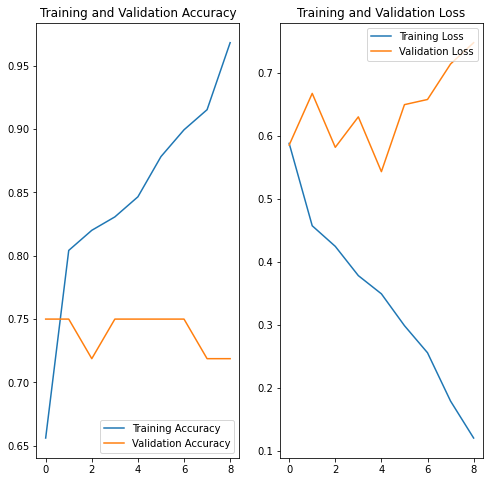

In [14]:
# visualize the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(early_stop.stopped_epoch + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [15]:
# make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.squeeze(y_pred).round().astype(int)

In [16]:
# classifiation report
from sklearn.metrics import classification_report , confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.64      0.69        14
           1       0.75      0.83      0.79        18

    accuracy                           0.75        32
   macro avg       0.75      0.74      0.74        32
weighted avg       0.75      0.75      0.75        32



In [17]:
# confusion matrix
actual_labels = ['no_tumor', 'tumor']
pred_labels = ['predicted_no_tumor', 'predicted_tumor']
matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(matrix, index=actual_labels, columns=pred_labels)
matrix_df

,predicted_no_tumor,predicted_tumor
no_tumor,9,5
tumor,3,15
